# Predicción de precios de acciones de REP.MC usando el modelo Black-Scholes

Este notebook descarga datos diarios de los precios de las acciones de Repsol (REP.MC) desde Yahoo Finance usando la librería `yfinance`, y aplica el modelo de Black-Scholes para predecir el precio de la acción a 30 días desde la fecha actual. Se incluyen gráficos relevantes para el análisis.

## Teoría y explicación del modelo Black-Scholes

El modelo de Black-Scholes es una fórmula matemática utilizada para calcular el precio teórico de opciones financieras europeas. Supone que el precio del activo subyacente sigue un movimiento browniano geométrico con volatilidad y tasa de interés constantes. La fórmula para una opción call europea es:

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2)
$$

donde:
- $C$ es el precio de la opción call
- $S_0$ es el precio actual del activo subyacente
- $K$ es el precio de ejercicio (strike)
- $r$ es la tasa libre de riesgo
- $T$ es el tiempo hasta el vencimiento (en años)
- $N(\cdot)$ es la función de distribución acumulada de la normal estándar
- $d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$
- $d_2 = d_1 - \sigma\sqrt{T}$

Este modelo permite estimar el valor justo de una opción bajo ciertas condiciones ideales.

In [63]:
# Instalación y carga de librerías necesarias
import sys
!{sys.executable} -m pip install --quiet yfinance matplotlib numpy scipy pandas
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime
import pandas as pd


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [64]:
# Descarga de datos de REP.MC desde el 1 de enero de 2025 hasta hoy
start_date = '2025-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
ticker = 'REP.MC'
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
if data.empty:
    raise ValueError('No se descargaron datos. Verifica el ticker o la conexión a internet.')
data = data.dropna()
data.head()

/tmp/ipykernel_13460/638683758.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume
Ticker,REP.MC,REP.MC,REP.MC,REP.MC,REP.MC
Date,,,,,
2025-01-02,10.949202,10.986130,10.829185,10.916890,4243232
2025-01-03,10.958434,11.041523,10.958434,11.004594,3513957
2025-01-06,11.092299,11.101530,10.939970,11.050754,17141341
2025-01-07,10.939971,11.064603,10.893811,10.958435,6095006
2025-01-08,10.889194,10.986131,10.769178,10.967667,4472355


In [65]:
# Guardar los datos descargados en un archivo CSV
data.to_csv('REP_MC_2025.csv')
print('Datos guardados en REP_MC_2025.csv')
data.head()

Datos guardados en REP_MC_2025.csv


Price,Close,High,Low,Open,Volume
Ticker,REP.MC,REP.MC,REP.MC,REP.MC,REP.MC
Date,,,,,
2025-01-02,10.949202,10.986130,10.829185,10.916890,4243232
2025-01-03,10.958434,11.041523,10.958434,11.004594,3513957
2025-01-06,11.092299,11.101530,10.939970,11.050754,17141341
2025-01-07,10.939971,11.064603,10.893811,10.958435,6095006
2025-01-08,10.889194,10.986131,10.769178,10.967667,4472355


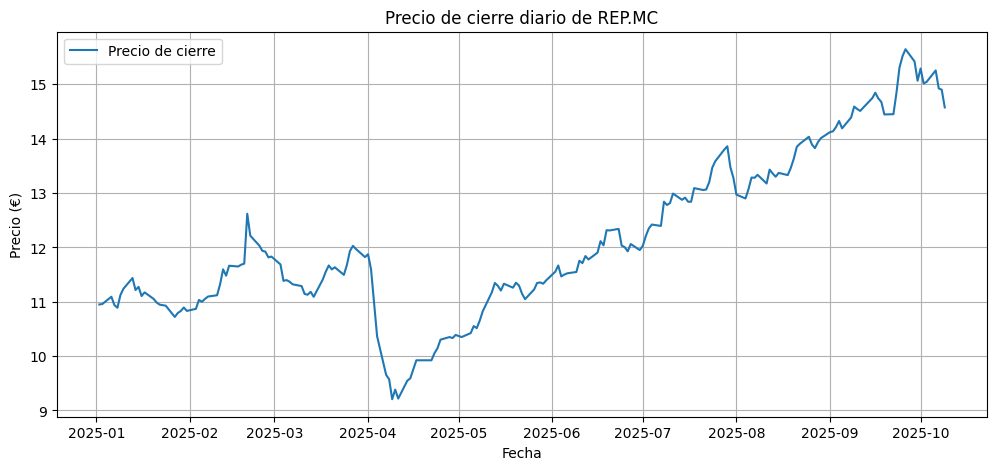

In [66]:
# Gráfico del precio de cierre diario
if 'Close' not in data.columns:
    raise KeyError('La columna "Close" no está en los datos descargados.')
plt.figure(figsize=(12,5))
plt.plot(data['Close'], label='Precio de cierre')
plt.title('Precio de cierre diario de REP.MC')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Cálculo de la volatilidad histórica anualizada y otros parámetros para Black-Scholes
returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
volatility = float(returns.std() * np.sqrt(252))  # 252 días de mercado al año
S0 = float(data['Close'].iloc[-1])  # Precio actual
K = S0  # Precio strike igual al actual (at-the-money)
r = 0.03  # Supongamos un 3% de tasa libre de riesgo anual
T = 30/252  # 30 días en años
print(f"Precio actual: {S0:.2f} €\nVolatilidad anualizada: {volatility:.2%}\nTasa libre de riesgo: {r:.2%}\nTiempo a vencimiento: {T:.3f} años")

Precio actual: 14.57 €
Volatilidad anualizada: 25.06%
Tasa libre de riesgo: 3.00%
Tiempo a vencimiento: 0.119 años


/tmp/ipykernel_13460/3153360427.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  volatility = float(returns.std() * np.sqrt(252))  # 252 días de mercado al año
/tmp/ipykernel_13460/3153360427.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(data['Close'].iloc[-1])  # Precio actual


In [68]:
# Implementación de la fórmula de Black-Scholes para una opción call europea
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

call_price = black_scholes_call(S0, K, T, r, volatility)
print(f"Precio estimado de la opción call (30 días): {call_price:.2f} €")

Precio estimado de la opción call (30 días): 0.53 €


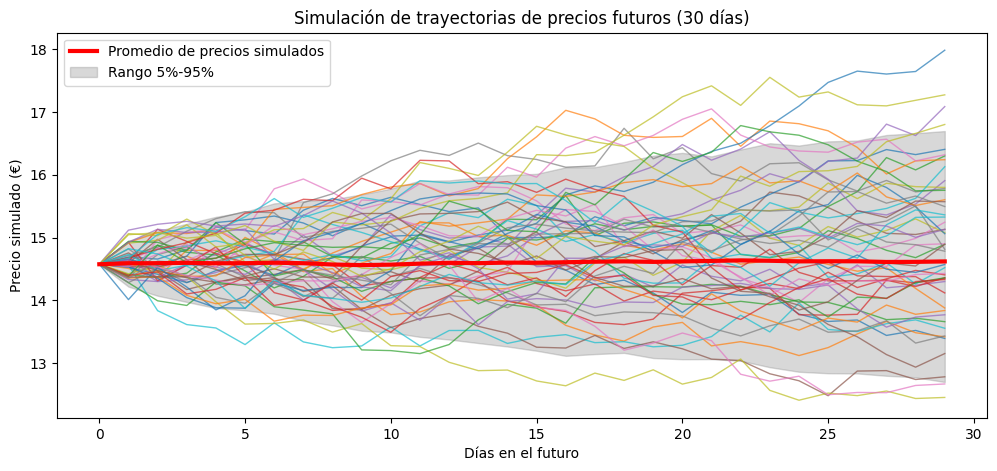

In [69]:
# Simulación de precios futuros bajo el supuesto de Black-Scholes
np.random.seed(42)
N = 30  # días a simular
simulaciones = 1000
precios_futuros = np.zeros((N, simulaciones))
for i in range(simulaciones):
    precios = [S0]
    for t in range(1, N):
        drift = (r - 0.5 * volatility ** 2) / 252
        shock = volatility * np.random.normal() / np.sqrt(252)
        precios.append(precios[-1] * np.exp(drift + shock))
    precios_futuros[:, i] = precios

plt.figure(figsize=(12,5))
# Graficar 50 trayectorias en distintos colores
for i in range(50):
    plt.plot(precios_futuros[:, i], alpha=0.7, lw=1)
# Línea del promedio resaltada
mean_path = precios_futuros.mean(axis=1)
plt.plot(mean_path, color='red', lw=3, label='Promedio de precios simulados')
# Límites percentiles
p5 = np.percentile(precios_futuros, 5, axis=1)
p95 = np.percentile(precios_futuros, 95, axis=1)
plt.fill_between(range(N), p5, p95, color='gray', alpha=0.3, label='Rango 5%-95%')
plt.title('Simulación de trayectorias de precios futuros (30 días)')
plt.xlabel('Días en el futuro')
plt.ylabel('Precio simulado (€)')
plt.legend()
plt.show()

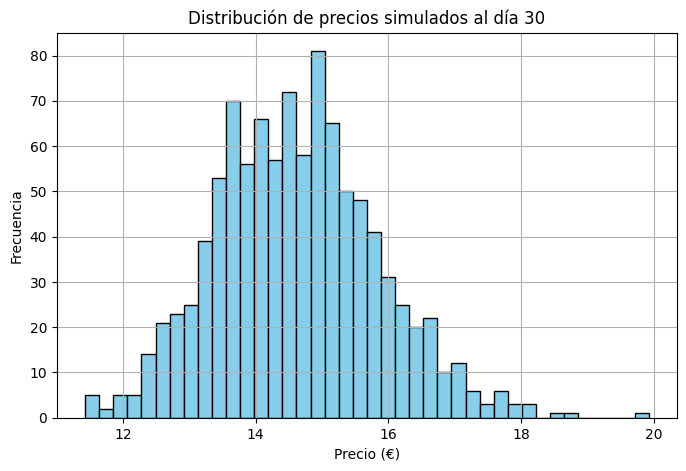

In [70]:
# Gráfico de distribución de precios simulados al día 30
plt.figure(figsize=(8,5))
plt.hist(precios_futuros[-1], bins=40, color='skyblue', edgecolor='black')
plt.title('Distribución de precios simulados al día 30')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

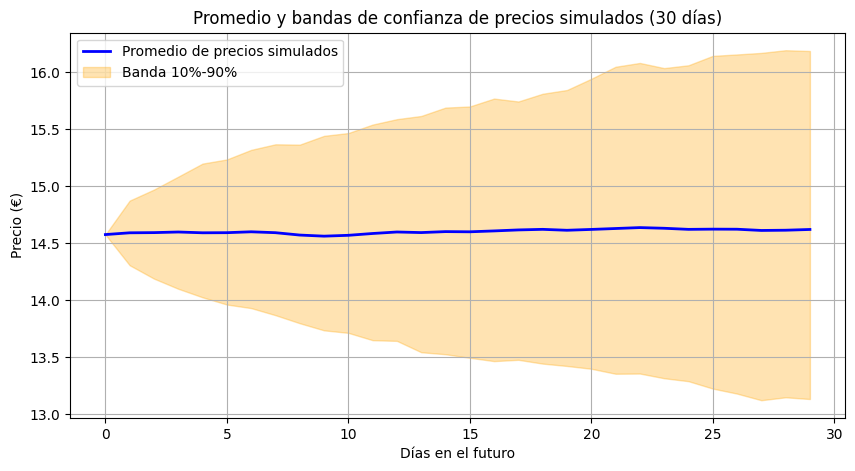

In [71]:
# Gráfico adicional: evolución del promedio y bandas de confianza
mean_path = precios_futuros.mean(axis=1)
p10 = np.percentile(precios_futuros, 10, axis=1)
p90 = np.percentile(precios_futuros, 90, axis=1)

plt.figure(figsize=(10,5))
plt.plot(mean_path, label='Promedio de precios simulados', color='blue', lw=2)
plt.fill_between(range(N), p10, p90, color='orange', alpha=0.3, label='Banda 10%-90%')
plt.title('Promedio y bandas de confianza de precios simulados (30 días)')
plt.xlabel('Días en el futuro')
plt.ylabel('Precio (€)')
plt.legend()
plt.grid(True)
plt.show()

## Interpretación de los resultados

- **Datos extraídos:** Se han descargado los precios diarios de las acciones de Repsol (REP.MC) desde el 1 de enero de 2025 hasta la fecha actual y se han guardado en el archivo `REP_MC_2025.csv`.
- **Volatilidad histórica:** La volatilidad anualizada calculada a partir de los retornos diarios refleja la variabilidad reciente del precio de la acción. Una mayor volatilidad implica mayor incertidumbre en la predicción de precios futuros.
- **Precio de la opción call:** El modelo Black-Scholes estima el valor justo de una opción call europea a 30 días, suponiendo condiciones ideales de mercado. Este valor es útil como referencia para comparar con precios de mercado reales.
- **Simulación de precios futuros:** Las trayectorias simuladas ahora muestran 50 caminos en distintos colores y un área sombreada que representa el rango entre los percentiles 5% y 95%, lo que permite visualizar la dispersión y los límites probables de los precios.
- **Gráfico adicional:** Se añadió un gráfico del promedio de los precios simulados y una banda de confianza (10%-90%), que ayuda a visualizar la tendencia central y la dispersión esperada de los precios a futuro.
- **Distribución de precios simulados:** El histograma final permite visualizar la probabilidad de distintos precios al cabo de 30 días, lo que ayuda a entender el riesgo y la posible dispersión de resultados.

**Conclusión:** El modelo Black-Scholes es una herramienta teórica poderosa, pero sus resultados deben interpretarse con cautela, ya que no contempla eventos inesperados ni cambios bruscos en la volatilidad o el mercado. Los gráficos mejorados permiten una mejor visualización de la incertidumbre y los posibles escenarios futuros.